In [ ]:
import numpy as np
import torch
import gymnasium as gym
import time
import matplotlib.pyplot as plt
!pip install swig
!pip install gymnasium[mujoco]
!pip install gymnasium[classic_control]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 61.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.5/243.5 kB 12.0 MB/s eta 0:00:00


In [ ]:

#AI assisted, code taken from source: https://www.geeksforgeeks.org/deep-learning/reinforcement-learning-using-pytorch/
#How do I get a default NN model from pytorch that I can use as a value function estimator for my RL algorithm code
import torch
import torch.nn as nn
from torch.distributions import Categorical
class actor_critic_dsc(nn.Module):
  def __init__(self, state_dim, action_dim, hidden = 128):
    super().__init__()
    self.pi_net = nn.Sequential(
      nn.Linear(state_dim, hidden),
      nn.ReLU(),
      nn.Linear(hidden, hidden),
      nn.ReLU(),
      nn.Linear(hidden, action_dim)
    )
    self.v_net = nn.Sequential(
      nn.Linear(state_dim, hidden),
      nn.ReLU(),
      nn.Linear(hidden, hidden),
      nn.ReLU(),
      nn.Linear(hidden, 1)
    )

  def policy(self, state):
    logits = self.pi_net(state)
    return Categorical(logits=logits)

  def value(self, state):
    return self.v_net(state).squeeze(-1)

  def forward(self, state):
    dist = self.policy(state)
    V = self.value(state)
    return dist, V

In [ ]:
#AI assisted, code taken from source: https://www.geeksforgeeks.org/deep-learning/reinforcement-learning-using-pytorch/
#How do I get a default NN model from pytorch that I can use as a value function estimator for my RL algorithm code
#extension to Continuous action space done with AI assistance
import torch
import torch.nn as nn
from torch.distributions import Categorical, Independent, Normal, TransformedDistribution
from torch.distributions.transforms import TanhTransform, AffineTransform
class actor_critic_cts(nn.Module):
  def __init__(self, state_dim, action_dim, hidden = 128, continuous = False, action_low = None, action_high = None, init_logstd = 0.0):
    super().__init__()
    self.continuous = continuous
    self.pi_net = nn.Sequential(
      nn.Linear(state_dim, hidden),
      nn.ReLU(),
      nn.Linear(hidden, hidden),
      nn.ReLU(),
    )
    if not self.continuous:
      self.pi_head = nn.Linear(hidden, action_dim)
    else:
      self.mu_head = nn.Linear(hidden, action_dim)
      self.log_std = nn.Parameter(torch.full((action_dim,), init_logstd))
      action_low  = torch.as_tensor(action_low,  dtype=torch.float32)
      action_high = torch.as_tensor(action_high, dtype=torch.float32)
      self.register_buffer("action_loc",   (action_high + action_low) / 2.0) #AI
      self.register_buffer("action_scale", (action_high - action_low) / 2.0) #AI

    self.v_net = nn.Sequential(
      nn.Linear(state_dim, hidden),
      nn.ReLU(),
      nn.Linear(hidden, hidden),
      nn.ReLU(),
      nn.Linear(hidden, 1)
    )

  def policy(self, state):
    h = self.pi_net(state)
    if not self.continuous:
      logits = self.pi_head(h)
      return Categorical(logits=logits)
    else:
      mu = self.mu_head(h)
      std = self.log_std.exp().expand_as(mu)
      base = Independent(Normal(mu, std), 1)
      return TransformedDistribution(  #AI
        base,
        [TanhTransform(cache_size=1),
         AffineTransform(loc=self.action_loc, scale=self.action_scale)]
      )

  def value(self, state):
    return self.v_net(state).squeeze(-1)

  def forward(self, state):
    dist = self.policy(state)
    V = self.value(state)
    return dist, V

In [ ]:
def reset_state(env):
  s, _  = env.reset()
  return s

In [ ]:
def GAE(r_hist, v_hist, next_val, traj_ends, y = 0.99, l = 0.95, terms = 150):
  r_hist = torch.tensor(r_hist, dtype=torch.float32)
  v_hist = torch.tensor(v_hist, dtype=torch.float32)
  traj_ends = torch.tensor(traj_ends, dtype=torch.float32)
  T = len(r_hist)
  v_tplus1 = torch.empty(T, dtype=torch.float32)
  if T > 1:
    v_tplus1[:-1] = v_hist[1:]
  if traj_ends[-1] == 1.0:
    v_tplus1[-1] = 0.0
  else:
    v_tplus1[-1] = next_val
  delta_in_t = r_hist + y*(1-traj_ends)*v_tplus1 - v_hist
  GAE_tensor = torch.zeros(T, dtype=torch.float32)
  for t in range(T):
    GAE_t = 0.0
    A_t_i = 0.0
    stop = 1.0
    y_factor = 1.0
    for i in range(1, 1 + min(T-t, terms)):
      A_t_i += stop*y_factor*delta_in_t[t + i-1]
      GAE_t += (l**(i-1))*A_t_i
      stop = stop * (1.0 - traj_ends[t + i-1])
      y_factor *= y
      if stop == 0.0:
          break
    GAE_tensor[t] = (1-l)*GAE_t
  return GAE_tensor


epoch 001/40 | steps(epoch) ~ 4000 | return μ  21.74 ± 13.24 (min   8.0, max  90.0) | pi_loss  0.0279 | v_loss 27.6036 | best μ  21.74 |  108.0s
epoch 002/40 | steps(epoch) ~ 4000 | return μ  23.95 ± 12.95 (min  10.0, max  78.0) | pi_loss -0.1483 | v_loss 28.7789 | best μ  23.95 |  203.7s
epoch 003/40 | steps(epoch) ~ 4000 | return μ  30.30 ± 17.57 (min  10.0, max 118.0) | pi_loss -0.3035 | v_loss 45.2117 | best μ  30.30 |  296.5s
epoch 004/40 | steps(epoch) ~ 4000 | return μ  38.83 ± 24.88 (min   6.0, max 144.0) | pi_loss -0.4440 | v_loss 68.2416 | best μ  38.83 |  388.9s
epoch 005/40 | steps(epoch) ~ 4000 | return μ  40.00 ± 20.34 (min  12.0, max 112.0) | pi_loss -0.5273 | v_loss 62.9235 | best μ  40.00 |  486.7s
epoch 006/40 | steps(epoch) ~ 4000 | return μ  41.24 ± 21.86 (min  12.0, max 159.0) | pi_loss -0.6028 | v_loss 64.7435 | best μ  41.24 |  577.9s
epoch 007/40 | steps(epoch) ~ 4000 | return μ  49.38 ± 23.50 (min  20.0, max 158.0) | pi_loss  0.0862 | v_loss 79.3932 | best μ  4

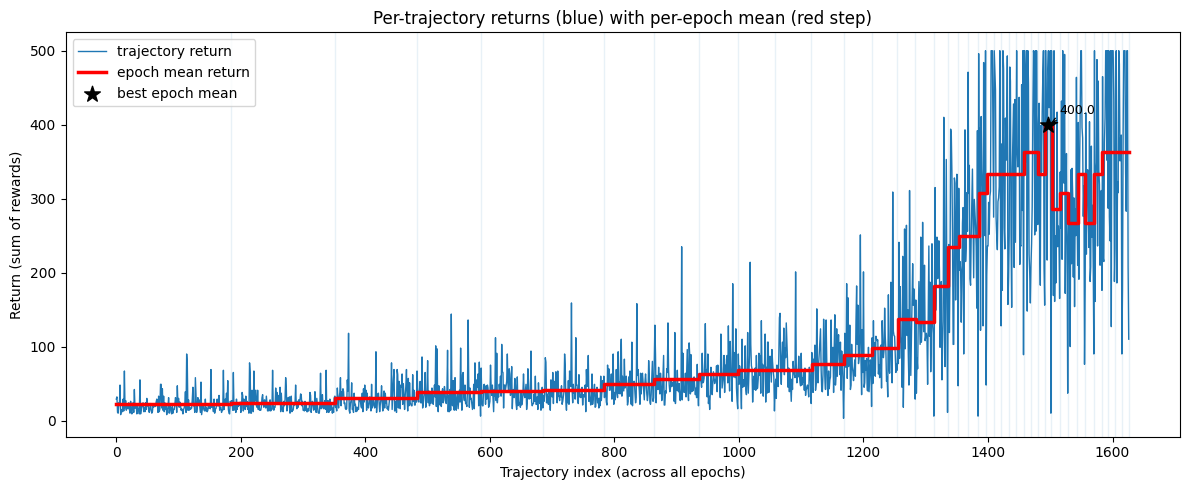

In [ ]:
#C A R T P O L E
env = gym.make("CartPole-v1")
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
total_timesteps = 4000 #timesetps taken in each epoch
traj_max_timesteps = 1000
num_epochs = 40
num_GAE_terms = 150
stepsize_w = 1e-3
stepsize_theta = 3e-3
run_start_time = time.time()
best_mean_return = -float("inf")
net = actor_critic_dsc(state_dim, action_dim, hidden=128).to("cpu")

w = list(net.v_net.parameters())
theta = list(net.pi_net.parameters())

"""
SGD(lr=0.5) on both actor and critic is extremely high for VPG with neural nets
and categorical policies, and plain SGD here is brittle.
Switching to Adam with small lrs is a vanilla change (not clipping/normalization)
and typically the difference between crawling and clean convergence.
"""
actor_update = torch.optim.Adam(theta, lr=stepsize_theta)
critic_update = torch.optim.Adam(w, lr=stepsize_w)

all_traj_returns = []          # mean reward per trajectory (sum/length)
all_traj_epochs = []         # epoch index for each trajectory
epoch_spans = []

for k in range(num_epochs):
    epoch_states, epoch_actions, epoch_vals, epoch_adv, epoch_returns = [], [], [], [], [] # data for each trajectory roll-out
    epoch_t = 0;
    traj_returns = []
    epoch_start_idx = len(all_traj_returns)
    while epoch_t < total_timesteps:
      s = reset_state(env)
      traj_states, traj_actions, traj_vals, traj_rews, traj_ends = [], [], [], [], [] # data for each trajectory roll-out
      done = False
      traj_t = 0
      while (not done) and (traj_t<traj_max_timesteps):
        s = torch.as_tensor(s, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
          dist, V = net(s)
          a = dist.sample()
          logp_a = dist.log_prob(a)
        s_next, r, terminated, truncated, _ = env.step(a.item())
        done = terminated or truncated #use this instead of a defined for loop, because in gymnasium the trajectory might terminate in the environment when some success/failure conditions are met
        traj_rews.append(r)
        traj_states.append(s.squeeze(0))
        traj_vals.append(V.item())
        traj_actions.append(a.item())
        """terminated = true environment terminal (pole fell) → mask it.
            truncated = time limit → do not mask; bootstrap with V_sT
        """
        traj_ends.append(1.0 if terminated else 0.0)
        s = s_next
        traj_t += 1
        epoch_t += 1
      # AI IDENTIFIED FIXES
        if epoch_t >= total_timesteps:      # FIX: stop collecting if epoch budget reached
            break
      # ---- prevent ends[-1] crash if trajectory collected 0 steps ----
      if len(traj_rews) == 0:               # FIX: skip empty trajectories
        continue
      rews  = torch.tensor(traj_rews,  dtype=torch.float32)
      vals  = torch.tensor(traj_vals,  dtype=torch.float32)
      ends = torch.tensor(traj_ends, dtype=torch.float32)

      if ends[-1] == 1.0:  #implementation and use of dones to handle the ends of trajectory by truncation or termination was implemented with ChatGPT 5 assistance
        next_v = 0.0
      else:
        s_tplus1 = torch.as_tensor(s, dtype=torch.float32, device="cpu").unsqueeze(0) #obtain the state after the last action taken before trajectory ended
        with torch.no_grad(): #AI provided. Used so that our value function is a constant, and estimated strictly through NN output, and does not give along the graph
                              #that generated the next_v
                              #using .item() does ensure in part that the graph is not given along,
                              #but no_grad() allows us to have entirely skip the computation of the generation graph
            next_v = net.value(s_tplus1).item()

      A = GAE(traj_rews, traj_vals, next_v, traj_ends)
      ret = A + torch.tensor(traj_vals, dtype=torch.float32)

      epoch_states.extend(traj_states)
      epoch_actions.extend(traj_actions)
      epoch_vals.extend(traj_vals)
      epoch_adv.extend(A.tolist())
      epoch_returns.extend(ret.tolist())

      traj_len = len(traj_rews)
      # after a trajectory finishes
      traj_return = rews.sum().item()             # <-- sum, not mean
      traj_returns.append(traj_return)

      all_traj_returns.append(traj_return)        # rename your list
      all_traj_epochs.append(k)

    if len(epoch_states) == 0:
      print("empty epoch; continuing")
      continue

    mean_trajreward = float(np.mean(traj_returns))  if len(traj_returns) > 0 else 0.0
    std_trajreward  = float(np.std(traj_returns))  if len(traj_returns) > 0 else 0.0
    min_trajreward  = float(np.min(traj_returns))  if len(traj_returns) > 0 else 0.0
    max_trajreward  = float(np.max(traj_returns))  if len(traj_returns) > 0 else 0.0

    state_t = torch.stack(epoch_states).to(torch.float32)
    action_t = torch.tensor(epoch_actions, dtype=torch.int64)
    adv_t = torch.tensor(epoch_adv, dtype=torch.float32)
    ret_t = torch.tensor(epoch_returns, dtype=torch.float32)

    v_step = net.value(state_t).squeeze(-1)                                  # V(s_t) (with grad)
    value_loss = torch.nn.functional.mse_loss(v_step, ret_t.detach())
    critic_update.zero_grad(); value_loss.backward(); critic_update.step()


    dist = net.policy(state_t)
    logp_t = dist.log_prob(action_t)

    log_trans = []

    for i in range(logp_t.shape[0]):
      grads = torch.autograd.grad(logp_t[i], theta, retain_graph = (i+1<logp_t.shape[0]), create_graph = False)
      logtrans_i = torch.cat([g.reshape(-1) for g in grads]).detach()
      log_trans.append(logtrans_i)
    log_trans = torch.stack(log_trans, dim = 0)
    v = torch.nn.Parameter(torch.zeros(log_trans.shape[1], device="cpu"))
    v_opt = torch.optim.Adam([v], lr=1e-3)

    for _ in range(10):
      v_opt.zero_grad()
      loss = ((log_trans @ v - adv_t.detach())**2).mean()
      loss.backward()
      v_opt.step()

    with torch.no_grad():
      F = (log_trans.T @ log_trans)/log_trans.shape[0]
      vFv = (v @ (F @ v)).item()
      delta = 0.01
      scale = ((2.0 * delta)/(vFv + 1e-12))**0.5
      step_vec = (scale * v).detach()

    actor_update.zero_grad()
    from torch.nn.utils import parameters_to_vector
    theta_vec = parameters_to_vector(theta)
    loss_TRPO = torch.dot(theta_vec, -step_vec) # ∂/∂θ (θ·(-step)) = -step
    loss_TRPO.backward()                         # sets p.grad = -step_slice for each param
    actor_update.step()

    pi_loss_val = float(loss_TRPO.item())
    v_loss_val  = float(value_loss.item())

    elapsed = time.time() - run_start_time
    if mean_trajreward > best_mean_return:
        best_mean_return = mean_trajreward
        torch.save(
            {
                "model": net.state_dict(),
                "actor_opt": actor_update.state_dict(),
                "critic_opt": critic_update.state_dict(),
                "epoch": k,
                "best_mean_return": best_mean_return,
            },
            "actor_critic_best.pt",
        )

    print(
    f"epoch {k+1:03d}/{num_epochs} | steps(epoch) ~{len(epoch_returns):5d} "
    f"| return μ {mean_trajreward:6.2f} ± {std_trajreward:5.2f} (min {min_trajreward:5.1f}, max {max_trajreward:5.1f}) "
    f"| pi_loss {pi_loss_val:7.4f} | v_loss {v_loss_val:7.4f} "
    f"| best μ {best_mean_return:6.2f} | {elapsed:6.1f}s")
    epoch_end_idx = len(all_traj_returns)   # one past the last traj index of this epoch
    epoch_mean_for_plot = float(np.mean(all_traj_returns[epoch_start_idx:epoch_end_idx])) if epoch_end_idx > epoch_start_idx else np.nan
    epoch_spans.append((epoch_start_idx, epoch_end_idx, epoch_mean_for_plot))
# x-axis = global trajectory index
x = np.arange(len(all_traj_returns))

plt.figure(figsize=(12,5))

# 1) per-trajectory returns (blue)
traj_line, = plt.plot(x, all_traj_returns, linewidth=1.0, label="trajectory return")

# 2) per-epoch mean as a red step line (built from epoch_spans)
xs, ys = [], []
for (s, e, m) in epoch_spans:
    if e > s and np.isfinite(m):
        xs += [s, e]
        ys += [m, m]
epoch_step = None
if xs:
    epoch_step = plt.step(xs, ys, where="post", color="red", linewidth=2.5, label="epoch mean return")

# (optional) faint epoch boundaries — no legend for these
for (s, e, _) in epoch_spans:
    plt.axvline(e - 0.5, alpha=0.1, linewidth=1)

# 3) mark best epoch mean with a black star
best_scatter = None
valid = [(i, s, e, m) for i, (s, e, m) in enumerate(epoch_spans) if np.isfinite(m) and e > s]
if valid:
    i_best, s_best, e_best, m_best = max(valid, key=lambda t: t[3])
    x_best = 0.5 * (s_best + e_best - 1)
    best_scatter = plt.scatter([x_best], [m_best], marker='*', s=140, color='black', zorder=6, label='best epoch mean')
    plt.annotate(f"{m_best:.1f}", xy=(x_best, m_best), xytext=(8, 8),
                 textcoords="offset points", fontsize=9,
                 arrowprops=dict(arrowstyle="->", lw=1))

plt.xlabel("Trajectory index (across all epochs)")
plt.ylabel("Return (sum of rewards)")
plt.title("Per-trajectory returns (blue) with per-epoch mean (red step)")
plt.legend()  # uses labels set above
plt.tight_layout()
plt.show()

epoch 001/40 | steps(epoch) ~ 4000 | return μ   5.07 ±  3.53 (min   2.0, max  28.0) | pi_loss  0.2929 | v_loss  1.2608 | best μ   5.07 |   96.2s
epoch 002/40 | steps(epoch) ~ 4000 | return μ   5.24 ±  3.60 (min   2.0, max  23.0) | pi_loss -0.3169 | v_loss  1.3453 | best μ   5.24 |  186.6s
epoch 003/40 | steps(epoch) ~ 4000 | return μ   6.68 ±  4.97 (min   2.0, max  34.0) | pi_loss -0.3903 | v_loss  2.9570 | best μ   6.68 |  277.6s
epoch 004/40 | steps(epoch) ~ 4000 | return μ   6.83 ±  5.21 (min   2.0, max  42.0) | pi_loss -0.6718 | v_loss  3.3918 | best μ   6.83 |  367.3s
epoch 005/40 | steps(epoch) ~ 4000 | return μ   7.72 ±  6.44 (min   2.0, max  41.0) | pi_loss -0.8730 | v_loss  5.5728 | best μ   7.72 |  456.5s
epoch 006/40 | steps(epoch) ~ 4000 | return μ   8.13 ±  6.56 (min   2.0, max  44.0) | pi_loss -0.8434 | v_loss  5.8129 | best μ   8.13 |  550.5s
epoch 007/40 | steps(epoch) ~ 4000 | return μ   9.99 ±  7.91 (min   2.0, max  50.0) | pi_loss -0.9049 | v_loss  8.5737 | best μ   

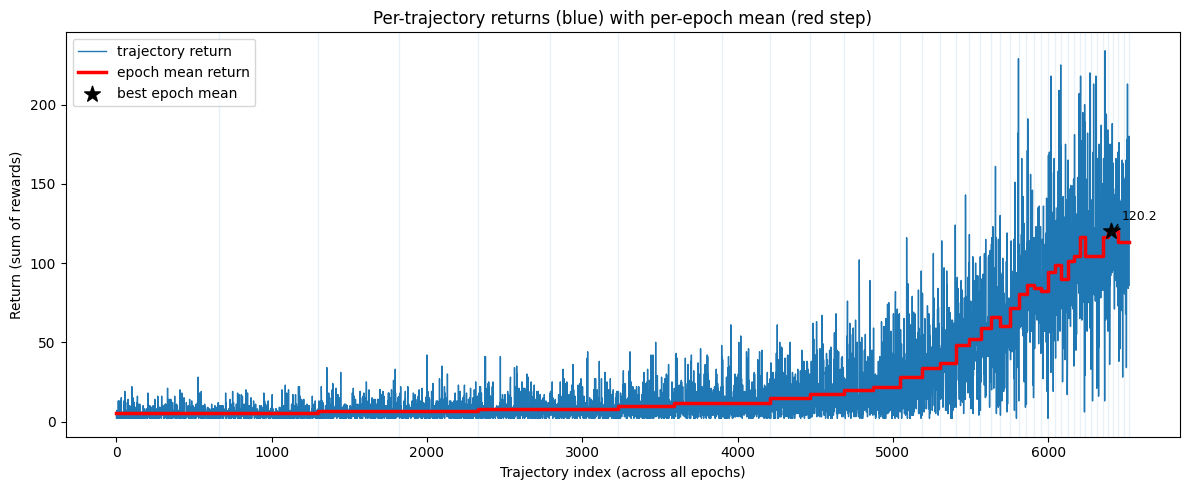

In [ ]:
#I N V E R T E D  P E N D U L U M

env_pen = gym.make("InvertedPendulum-v5")
state_dim = env_pen.observation_space.shape[0]
action_space = env_pen.action_space
total_timesteps = 4000 #timesetps taken in each epoch
traj_max_timesteps = 1001
num_epochs = 40
num_GAE_terms = 150
stepsize_w = 1e-3
stepsize_theta = 3e-3
run_start_time = time.time()
best_mean_return = -float("inf")
net = actor_critic_cts(state_dim, action_dim = action_space.shape[0], hidden=128, continuous=True, action_low=action_space.low, action_high=action_space.high).to("cpu")

w = list(net.v_net.parameters())

"""
SGD(lr=0.5) on both actor and critic is extremely high for VPG with neural nets
and categorical policies, and plain SGD here is brittle.
Switching to Adam with small lrs is a vanilla change (not clipping/normalization)
and typically the difference between crawling and clean convergence.
"""
actor_params = list(net.pi_net.parameters())
if net.continuous:
    actor_params += list(net.mu_head.parameters()) + [net.log_std]
else:
    actor_params += list(net.pi_head.parameters())
actor_update = torch.optim.Adam(actor_params, lr=stepsize_theta)
theta = actor_params
critic_update = torch.optim.Adam(w, lr=stepsize_w)

all_traj_returns = []          # mean reward per trajectory (sum/length)
all_traj_epochs = []         # epoch index for each trajectory
epoch_spans = []

for k in range(num_epochs):
    epoch_states, epoch_actions, epoch_vals, epoch_adv, epoch_returns = [], [], [], [], [] # data for each trajectory roll-out
    epoch_t = 0;
    epoch_logp = []
    traj_returns = []
    epoch_start_idx = len(all_traj_returns)
    while epoch_t < total_timesteps:
      s = reset_state(env_pen)
      traj_states, traj_actions, traj_vals, traj_rews, traj_ends = [], [], [], [], [] # data for each trajectory roll-out
      done = False
      traj_t = 0
      while (not done) and (traj_t<traj_max_timesteps):
        s = torch.as_tensor(s, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
          dist, V = net(s)
          a = dist.sample()
          logp_a = dist.log_prob(a)
        a_env = a.squeeze(0).cpu().numpy().astype(np.float32)  #AI
        s_next, r, terminated, truncated, _ = env_pen.step(a_env)
        done = terminated or truncated #use this instead of a defined for loop, because in gymnasium the trajectory might terminate in the environment when some success/failure conditions are met
        traj_rews.append(r)
        traj_states.append(s.squeeze(0))
        traj_vals.append(V.item())
        traj_actions.append(a.squeeze(0))
        epoch_logp.append(logp_a.squeeze(0))
        """terminated = true environment terminal → mask it.
            truncated = time limit → do not mask; bootstrap with V_sT
        """
        traj_ends.append(1.0 if terminated else 0.0)
        s = s_next
        traj_t += 1
        epoch_t += 1
      # AI IDENTIFIED FIXES
        if epoch_t >= total_timesteps:      # FIX: stop collecting if epoch budget reached
            break
      # ---- prevent ends[-1] crash if trajectory collected 0 steps ----
      if len(traj_rews) == 0:               # FIX: skip empty trajectories
        continue
      rews  = torch.tensor(traj_rews,  dtype=torch.float32)
      vals  = torch.tensor(traj_vals,  dtype=torch.float32)
      ends = torch.tensor(traj_ends, dtype=torch.float32)

      if ends[-1] == 1.0:  #implementation and use of dones to handle the ends of trajectory by truncation or termination was implemented with ChatGPT 5 assistance
        next_v = 0.0
      else:
        s_tplus1 = torch.as_tensor(s, dtype=torch.float32, device="cpu").unsqueeze(0) #obtain the state after the last action taken before trajectory ended
        with torch.no_grad(): #AI provided. Used so that our value function is a constant, and estimated strictly through NN output, and does not give along the graph
                              #that generated the next_v
                              #using .item() does ensure in part that the graph is not given along,
                              #but no_grad() allows us to have entirely skip the computation of the generation graph
            next_v = net.value(s_tplus1).item()

      A = GAE(traj_rews, traj_vals, next_v, traj_ends)
      ret = A + torch.tensor(traj_vals, dtype=torch.float32)

      epoch_states.extend(traj_states)
      epoch_actions.extend(traj_actions)
      epoch_vals.extend(traj_vals)
      epoch_adv.extend(A.tolist())
      epoch_returns.extend(ret.tolist())

      traj_len = len(traj_rews)
      # after a trajectory finishes
      traj_return = rews.sum().item()             # <-- sum, not mean
      traj_returns.append(traj_return)

      all_traj_returns.append(traj_return)        # rename your list
      all_traj_epochs.append(k)

    if len(epoch_states) == 0:
      print("empty epoch; continuing")
      continue

    mean_trajreward = float(np.mean(traj_returns))  if len(traj_returns) > 0 else 0.0
    std_trajreward  = float(np.std(traj_returns))  if len(traj_returns) > 0 else 0.0
    min_trajreward  = float(np.min(traj_returns))  if len(traj_returns) > 0 else 0.0
    max_trajreward  = float(np.max(traj_returns))  if len(traj_returns) > 0 else 0.0

    state_t = torch.stack(epoch_states).to(torch.float32)
    action_t = torch.stack(epoch_actions).to(torch.float32)
    adv_t = torch.tensor(epoch_adv, dtype=torch.float32)
    ret_t = torch.tensor(epoch_returns, dtype=torch.float32)

    v_step = net.value(state_t).squeeze(-1)                                  # V(s_t) (with grad)
    value_loss = torch.nn.functional.mse_loss(v_step, ret_t.detach())
    critic_update.zero_grad(); value_loss.backward(); critic_update.step()

    dist = net.policy(state_t)
    # Clamp actions into open interval so atanh is well-defined when re-computing log_prob
    ###AIstart
    eps = 1e-6
    low  = (net.action_loc - net.action_scale + eps).unsqueeze(0)
    high = (net.action_loc + net.action_scale - eps).unsqueeze(0)
    action_t_clamped = torch.max(torch.min(action_t, high), low)
    ###AIend

    logp_t = dist.log_prob(action_t_clamped)

    log_trans = []

    for i in range(logp_t.shape[0]):
      grads = torch.autograd.grad(logp_t[i], theta, retain_graph = True, create_graph = False)
      logtrans_i = torch.cat([g.reshape(-1) for g in grads]).detach()
      log_trans.append(logtrans_i)
    log_trans = torch.stack(log_trans, dim = 0)
    v = torch.nn.Parameter(torch.zeros(log_trans.shape[1], device="cpu"))
    v_opt = torch.optim.Adam([v], lr=1e-3)

    for _ in range(10):
      v_opt.zero_grad()
      loss = ((log_trans @ v - adv_t.detach())**2).mean()
      loss.backward()
      v_opt.step()

    with torch.no_grad():
      F = (log_trans.T @ log_trans)/log_trans.shape[0]
      vFv = (v @ (F @ v)).item()
      delta = 0.01
      scale = ((2.0 * delta)/(vFv + 1e-12))**0.5
      step_vec = (scale * v).detach()

    actor_update.zero_grad()
    from torch.nn.utils import parameters_to_vector
    theta_vec = parameters_to_vector(theta)
    loss_TRPO = torch.dot(theta_vec, -step_vec) # ∂/∂θ (θ·(-step)) = -step
    loss_TRPO.backward()                         # sets p.grad = -step_slice for each param
    actor_update.step()

    pi_loss_val = float(loss_TRPO.item())
    v_loss_val  = float(value_loss.item())

    elapsed = time.time() - run_start_time
    if mean_trajreward > best_mean_return:
        best_mean_return = mean_trajreward
        torch.save(
            {
                "model": net.state_dict(),
                "actor_opt": actor_update.state_dict(),
                "critic_opt": critic_update.state_dict(),
                "epoch": k,
                "best_mean_return": best_mean_return,
            },
            "actor_critic_best_2.pt",
        )

    print(
    f"epoch {k+1:03d}/{num_epochs} | steps(epoch) ~{len(epoch_returns):5d} "
    f"| return μ {mean_trajreward:6.2f} ± {std_trajreward:5.2f} (min {min_trajreward:5.1f}, max {max_trajreward:5.1f}) "
    f"| pi_loss {pi_loss_val:7.4f} | v_loss {v_loss_val:7.4f} "
    f"| best μ {best_mean_return:6.2f} | {elapsed:6.1f}s")
    epoch_end_idx = len(all_traj_returns)   # one past the last traj index of this epoch
    epoch_mean_for_plot = float(np.mean(all_traj_returns[epoch_start_idx:epoch_end_idx])) if epoch_end_idx > epoch_start_idx else np.nan
    epoch_spans.append((epoch_start_idx, epoch_end_idx, epoch_mean_for_plot))

# x-axis = global trajectory index
x = np.arange(len(all_traj_returns))

plt.figure(figsize=(12,5))

# 1) per-trajectory returns (blue)
traj_line, = plt.plot(x, all_traj_returns, linewidth=1.0, label="trajectory return")

# 2) per-epoch mean as a red step line (built from epoch_spans)
xs, ys = [], []
for (s, e, m) in epoch_spans:
    if e > s and np.isfinite(m):
        xs += [s, e]
        ys += [m, m]
epoch_step = None
if xs:
    epoch_step = plt.step(xs, ys, where="post", color="red", linewidth=2.5, label="epoch mean return")

# (optional) faint epoch boundaries — no legend for these
for (s, e, _) in epoch_spans:
    plt.axvline(e - 0.5, alpha=0.1, linewidth=1)

# 3) mark best epoch mean with a black star
best_scatter = None
valid = [(i, s, e, m) for i, (s, e, m) in enumerate(epoch_spans) if np.isfinite(m) and e > s]
if valid:
    i_best, s_best, e_best, m_best = max(valid, key=lambda t: t[3])
    x_best = 0.5 * (s_best + e_best - 1)
    best_scatter = plt.scatter([x_best], [m_best], marker='*', s=140, color='black', zorder=6, label='best epoch mean')
    plt.annotate(f"{m_best:.1f}", xy=(x_best, m_best), xytext=(8, 8),
                 textcoords="offset points", fontsize=9,
                 arrowprops=dict(arrowstyle="->", lw=1))

plt.xlabel("Trajectory index (across all epochs)")
plt.ylabel("Return (sum of rewards)")
plt.title("Per-trajectory returns (blue) with per-epoch mean (red step)")
plt.legend()  # uses labels set above
plt.tight_layout()
plt.show()

epoch 001/40 | steps(epoch) ~ 4000 | return μ -138.66 ± 11.28 (min -153.1, max -121.4) | pi_loss -0.0011 | v_loss 10.9261 | best μ -138.66 |  114.3s
epoch 002/40 | steps(epoch) ~ 4000 | return μ -136.30 ± 24.54 (min -170.0, max -104.2) | pi_loss  0.0263 | v_loss  9.0505 | best μ -136.30 |  225.9s
epoch 003/40 | steps(epoch) ~ 4000 | return μ -114.30 ± 13.53 (min -136.5, max -103.0) | pi_loss -0.0157 | v_loss  6.6769 | best μ -114.30 |  339.7s
epoch 004/40 | steps(epoch) ~ 4000 | return μ -117.40 ± 41.35 (min -161.9, max -49.8) | pi_loss -0.0136 | v_loss  7.7192 | best μ -114.30 |  456.5s
epoch 005/40 | steps(epoch) ~ 4000 | return μ -104.69 ± 21.78 (min -134.8, max -73.3) | pi_loss -0.0064 | v_loss  6.7158 | best μ -104.69 |  581.4s
epoch 006/40 | steps(epoch) ~ 4000 | return μ -101.04 ± 15.15 (min -115.9, max -76.2) | pi_loss -0.0114 | v_loss  6.8009 | best μ -101.04 |  695.8s
epoch 007/40 | steps(epoch) ~ 4000 | return μ -112.82 ± 18.42 (min -143.2, max -94.1) | pi_loss  0.0135 | v_l

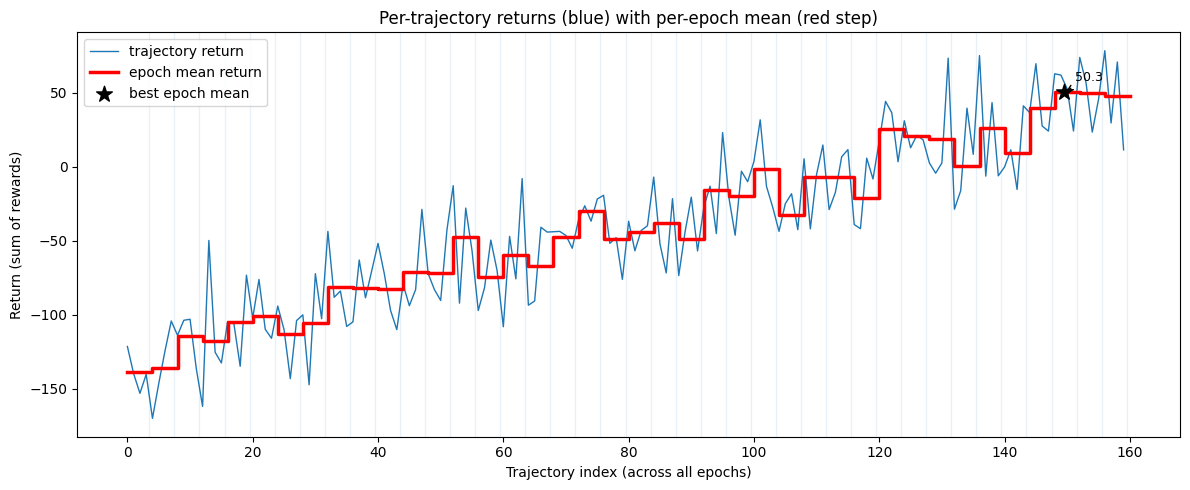

In [ ]:
env_pen = gym.make("HalfCheetah-v5")
state_dim = env_pen.observation_space.shape[0]
action_space = env_pen.action_space
total_timesteps = 4000 #timesetps taken in each epoch
traj_max_timesteps = 1001
num_epochs = 40
num_GAE_terms = 150
stepsize_w = 1e-3
stepsize_theta = 3e-4
run_start_time = time.time()
best_mean_return = -float("inf")
net = actor_critic_cts(state_dim, action_dim = action_space.shape[0], hidden=128, continuous=True, action_low=action_space.low, action_high=action_space.high, init_logstd=-1.0).to("cpu")

w = list(net.v_net.parameters())

"""
SGD(lr=0.5) on both actor and critic is extremely high for VPG with neural nets
and categorical policies, and plain SGD here is brittle.
Switching to Adam with small lrs is a vanilla change (not clipping/normalization)
and typically the difference between crawling and clean convergence.
"""
actor_params = list(net.pi_net.parameters())
if net.continuous:
    actor_params += list(net.mu_head.parameters()) + [net.log_std]
else:
    actor_params += list(net.pi_head.parameters())
actor_update = torch.optim.Adam(actor_params, lr=stepsize_theta)
theta = actor_params
critic_update = torch.optim.Adam(w, lr=stepsize_w)

all_traj_returns = []          # mean reward per trajectory (sum/length)
all_traj_epochs = []         # epoch index for each trajectory
epoch_spans = []

for k in range(num_epochs):
    epoch_states, epoch_actions, epoch_vals, epoch_adv, epoch_returns = [], [], [], [], [] # data for each trajectory roll-out
    epoch_t = 0;
    epoch_logp = []
    traj_returns = []
    epoch_start_idx = len(all_traj_returns)
    while epoch_t < total_timesteps:
      s = reset_state(env_pen)
      traj_states, traj_actions, traj_vals, traj_rews, traj_ends = [], [], [], [], [] # data for each trajectory roll-out
      done = False
      traj_t = 0
      while (not done) and (traj_t<traj_max_timesteps):
        s = torch.as_tensor(s, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
          dist, V = net(s)
          a = dist.sample()
          logp_a = dist.log_prob(a)
        a_env = a.squeeze(0).cpu().numpy().astype(np.float32)  #AI
        s_next, r, terminated, truncated, _ = env_pen.step(a_env)
        done = terminated or truncated #use this instead of a defined for loop, because in gymnasium the trajectory might terminate in the environment when some success/failure conditions are met
        traj_rews.append(r)
        traj_states.append(s.squeeze(0))
        traj_vals.append(V.item())
        traj_actions.append(a.squeeze(0))
        epoch_logp.append(logp_a.squeeze(0))
        """terminated = true environment terminal → mask it.
            truncated = time limit → do not mask; bootstrap with V_sT
        """
        traj_ends.append(1.0 if terminated else 0.0)
        s = s_next
        traj_t += 1
        epoch_t += 1
      # AI IDENTIFIED FIXES
        if epoch_t >= total_timesteps:      # FIX: stop collecting if epoch budget reached
            break
      # ---- prevent ends[-1] crash if trajectory collected 0 steps ----
      if len(traj_rews) == 0:               # FIX: skip empty trajectories
        continue
      rews  = torch.tensor(traj_rews,  dtype=torch.float32)
      vals  = torch.tensor(traj_vals,  dtype=torch.float32)
      ends = torch.tensor(traj_ends, dtype=torch.float32)

      if ends[-1] == 1.0:  #implementation and use of dones to handle the ends of trajectory by truncation or termination was implemented with ChatGPT 5 assistance
        next_v = 0.0
      else:
        s_tplus1 = torch.as_tensor(s, dtype=torch.float32, device="cpu").unsqueeze(0) #obtain the state after the last action taken before trajectory ended
        with torch.no_grad(): #AI provided. Used so that our value function is a constant, and estimated strictly through NN output, and does not give along the graph
                              #that generated the next_v
                              #using .item() does ensure in part that the graph is not given along,
                              #but no_grad() allows us to have entirely skip the computation of the generation graph
            next_v = net.value(s_tplus1).item()

      A = GAE(traj_rews, traj_vals, next_v, traj_ends)
      ret = A + torch.tensor(traj_vals, dtype=torch.float32)

      epoch_states.extend(traj_states)
      epoch_actions.extend(traj_actions)
      epoch_vals.extend(traj_vals)
      epoch_adv.extend(A.tolist())
      epoch_returns.extend(ret.tolist())

      traj_len = len(traj_rews)
      # after a trajectory finishes
      traj_return = rews.sum().item()             # <-- sum, not mean
      traj_returns.append(traj_return)

      all_traj_returns.append(traj_return)        # rename your list
      all_traj_epochs.append(k)

    if len(epoch_states) == 0:
      print("empty epoch; continuing")
      continue

    mean_trajreward = float(np.mean(traj_returns))  if len(traj_returns) > 0 else 0.0
    std_trajreward  = float(np.std(traj_returns))  if len(traj_returns) > 0 else 0.0
    min_trajreward  = float(np.min(traj_returns))  if len(traj_returns) > 0 else 0.0
    max_trajreward  = float(np.max(traj_returns))  if len(traj_returns) > 0 else 0.0

    state_t = torch.stack(epoch_states).to(torch.float32)
    action_t = torch.stack(epoch_actions).to(torch.float32)
    adv_t = torch.tensor(epoch_adv, dtype=torch.float32)
    ret_t = torch.tensor(epoch_returns, dtype=torch.float32)

    v_step = net.value(state_t).squeeze(-1)                                  # V(s_t) (with grad)
    value_loss = torch.nn.functional.mse_loss(v_step, ret_t.detach())
    critic_update.zero_grad(); value_loss.backward(); critic_update.step()

    dist = net.policy(state_t)
    # Clamp actions into open interval so atanh is well-defined when re-computing log_prob
    ###AIstart
    eps = 1e-6
    low  = (net.action_loc - net.action_scale + eps).unsqueeze(0)
    high = (net.action_loc + net.action_scale - eps).unsqueeze(0)
    action_t_clamped = torch.max(torch.min(action_t, high), low)
    ###AIend

    logp_t = dist.log_prob(action_t_clamped)

    log_trans = []

    for i in range(logp_t.shape[0]):
      grads = torch.autograd.grad(logp_t[i], theta, retain_graph = True, create_graph = False)
      logtrans_i = torch.cat([g.reshape(-1) for g in grads]).detach()
      log_trans.append(logtrans_i)
    log_trans = torch.stack(log_trans, dim = 0)
    v = torch.nn.Parameter(torch.zeros(log_trans.shape[1], device="cpu"))
    v_opt = torch.optim.Adam([v], lr=1e-3)

    for _ in range(10):
      v_opt.zero_grad()
      loss = ((log_trans @ v - adv_t.detach())**2).mean()
      loss.backward()
      v_opt.step()

    with torch.no_grad():
      F = (log_trans.T @ log_trans)/log_trans.shape[0]
      vFv = (v @ (F @ v)).item()
      delta = 0.01
      scale = ((2.0 * delta)/(vFv + 1e-12))**0.5
      step_vec = (scale * v).detach()

    actor_update.zero_grad()
    from torch.nn.utils import parameters_to_vector
    theta_vec = parameters_to_vector(theta)
    loss_TRPO = torch.dot(theta_vec, -step_vec) # ∂/∂θ (θ·(-step)) = -step
    loss_TRPO.backward()                         # sets p.grad = -step_slice for each param
    actor_update.step()

    pi_loss_val = float(loss_TRPO.item())
    v_loss_val  = float(value_loss.item())

    elapsed = time.time() - run_start_time
    if mean_trajreward > best_mean_return:
        best_mean_return = mean_trajreward
        torch.save(
            {
                "model": net.state_dict(),
                "actor_opt": actor_update.state_dict(),
                "critic_opt": critic_update.state_dict(),
                "epoch": k,
                "best_mean_return": best_mean_return,
            },
            "actor_critic_best_3.pt",
        )

    print(
    f"epoch {k+1:03d}/{num_epochs} | steps(epoch) ~{len(epoch_returns):5d} "
    f"| return μ {mean_trajreward:6.2f} ± {std_trajreward:5.2f} (min {min_trajreward:5.1f}, max {max_trajreward:5.1f}) "
    f"| pi_loss {pi_loss_val:7.4f} | v_loss {v_loss_val:7.4f} "
    f"| best μ {best_mean_return:6.2f} | {elapsed:6.1f}s")
    epoch_end_idx = len(all_traj_returns)   # one past the last traj index of this epoch
    epoch_mean_for_plot = float(np.mean(all_traj_returns[epoch_start_idx:epoch_end_idx])) if epoch_end_idx > epoch_start_idx else np.nan
    epoch_spans.append((epoch_start_idx, epoch_end_idx, epoch_mean_for_plot))

# x-axis = global trajectory index
x = np.arange(len(all_traj_returns))

plt.figure(figsize=(12,5))

# 1) per-trajectory returns (blue)
traj_line, = plt.plot(x, all_traj_returns, linewidth=1.0, label="trajectory return")

# 2) per-epoch mean as a red step line (built from epoch_spans)
xs, ys = [], []
for (s, e, m) in epoch_spans:
    if e > s and np.isfinite(m):
        xs += [s, e]
        ys += [m, m]
epoch_step = None
if xs:
    epoch_step = plt.step(xs, ys, where="post", color="red", linewidth=2.5, label="epoch mean return")

# (optional) faint epoch boundaries — no legend for these
for (s, e, _) in epoch_spans:
    plt.axvline(e - 0.5, alpha=0.1, linewidth=1)

# 3) mark best epoch mean with a black star
best_scatter = None
valid = [(i, s, e, m) for i, (s, e, m) in enumerate(epoch_spans) if np.isfinite(m) and e > s]
if valid:
    i_best, s_best, e_best, m_best = max(valid, key=lambda t: t[3])
    x_best = 0.5 * (s_best + e_best - 1)
    best_scatter = plt.scatter([x_best], [m_best], marker='*', s=140, color='black', zorder=6, label='best epoch mean')
    plt.annotate(f"{m_best:.1f}", xy=(x_best, m_best), xytext=(8, 8),
                 textcoords="offset points", fontsize=9,
                 arrowprops=dict(arrowstyle="->", lw=1))

plt.xlabel("Trajectory index (across all epochs)")
plt.ylabel("Return (sum of rewards)")
plt.title("Per-trajectory returns (blue) with per-epoch mean (red step)")
plt.legend()  # uses labels set above
plt.tight_layout()
plt.show()

epoch 001/40 | steps(epoch) ~ 4000 | return μ  -1.26 ±  4.68 (min  -8.7, max   4.2) | pi_loss  0.0140 | v_loss  7.3039 | best μ  -1.26 |  112.5s
epoch 002/40 | steps(epoch) ~ 4000 | return μ  -7.93 ±  5.84 (min -16.0, max   0.3) | pi_loss  0.0876 | v_loss  8.9645 | best μ  -1.26 |  217.4s
epoch 003/40 | steps(epoch) ~ 4000 | return μ   3.78 ±  3.10 (min  -0.4, max   6.8) | pi_loss -0.0126 | v_loss  9.4085 | best μ   3.78 |  323.7s
epoch 004/40 | steps(epoch) ~ 4000 | return μ  -3.69 ±  8.62 (min -18.4, max   2.4) | pi_loss -0.0780 | v_loss  8.0138 | best μ   3.78 |  428.1s
epoch 005/40 | steps(epoch) ~ 4000 | return μ  -1.92 ± 10.00 (min -17.1, max  10.4) | pi_loss -0.0365 | v_loss  6.0309 | best μ   3.78 |  534.5s
epoch 006/40 | steps(epoch) ~ 4000 | return μ  12.67 ±  8.83 (min   3.7, max  25.7) | pi_loss -0.0447 | v_loss 10.3539 | best μ  12.67 |  639.8s
epoch 007/40 | steps(epoch) ~ 4000 | return μ  13.94 ±  5.82 (min   7.6, max  23.4) | pi_loss -0.0908 | v_loss 10.2283 | best μ  1

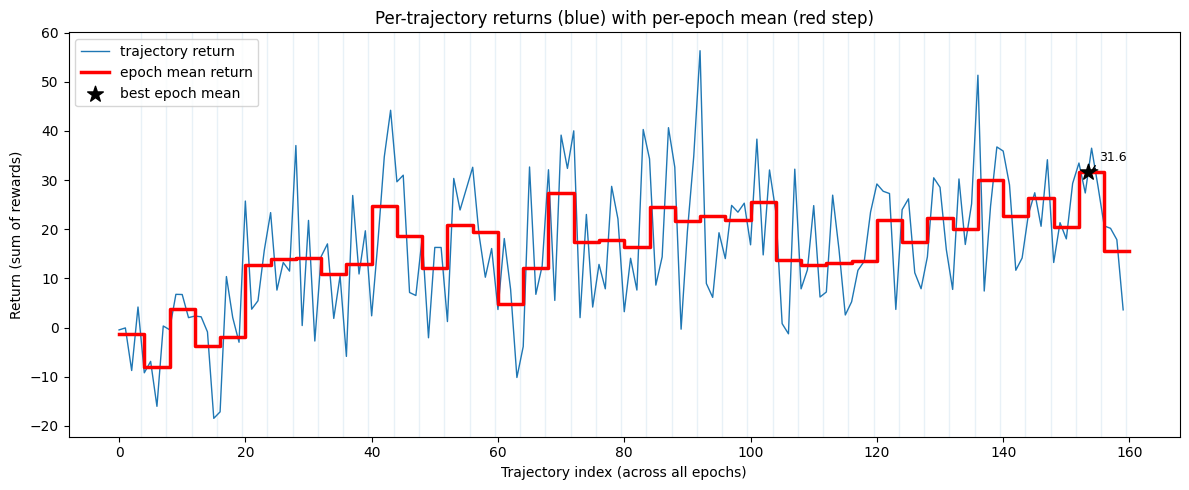

In [ ]:
env_pen = gym.make("Swimmer-v5")
state_dim = env_pen.observation_space.shape[0]
action_space = env_pen.action_space
total_timesteps = 4000 #timesetps taken in each epoch
traj_max_timesteps = 1001
num_epochs = 40
num_GAE_terms = 150
stepsize_w = 1e-3
stepsize_theta = 3e-4
run_start_time = time.time()
best_mean_return = -float("inf")
net = actor_critic_cts(state_dim, action_dim = action_space.shape[0], hidden=128, continuous=True, action_low=action_space.low, action_high=action_space.high).to("cpu")

w = list(net.v_net.parameters())

"""
SGD(lr=0.5) on both actor and critic is extremely high for VPG with neural nets
and categorical policies, and plain SGD here is brittle.
Switching to Adam with small lrs is a vanilla change (not clipping/normalization)
and typically the difference between crawling and clean convergence.
"""
actor_params = list(net.pi_net.parameters())
if net.continuous:
    actor_params += list(net.mu_head.parameters()) + [net.log_std]
else:
    actor_params += list(net.pi_head.parameters())
theta = actor_params
actor_update = torch.optim.Adam(actor_params, lr=stepsize_theta)

critic_update = torch.optim.Adam(w, lr=stepsize_w)

all_traj_returns = []          # mean reward per trajectory (sum/length)
all_traj_epochs = []         # epoch index for each trajectory
epoch_spans = []

for k in range(num_epochs):
    epoch_states, epoch_actions, epoch_vals, epoch_adv, epoch_returns = [], [], [], [], [] # data for each trajectory roll-out
    epoch_t = 0;
    epoch_logp = []
    traj_returns = []
    epoch_start_idx = len(all_traj_returns)
    while epoch_t < total_timesteps:
      s = reset_state(env_pen)
      traj_states, traj_actions, traj_vals, traj_rews, traj_ends = [], [], [], [], [] # data for each trajectory roll-out
      done = False
      traj_t = 0
      while (not done) and (traj_t<traj_max_timesteps):
        s = torch.as_tensor(s, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
          dist, V = net(s)
          a = dist.sample()
          logp_a = dist.log_prob(a)
        a_env = a.squeeze(0).cpu().numpy().astype(np.float32)  #AI
        s_next, r, terminated, truncated, _ = env_pen.step(a_env)
        done = terminated or truncated #use this instead of a defined for loop, because in gymnasium the trajectory might terminate in the environment when some success/failure conditions are met
        traj_rews.append(r)
        traj_states.append(s.squeeze(0))
        traj_vals.append(V.item())
        traj_actions.append(a.squeeze(0))
        epoch_logp.append(logp_a.squeeze(0))
        """terminated = true environment terminal → mask it.
            truncated = time limit → do not mask; bootstrap with V_sT
        """
        traj_ends.append(1.0 if terminated else 0.0)
        s = s_next
        traj_t += 1
        epoch_t += 1
      # AI IDENTIFIED FIXES
        if epoch_t >= total_timesteps:      # FIX: stop collecting if epoch budget reached
            break
      # ---- prevent ends[-1] crash if trajectory collected 0 steps ----
      if len(traj_rews) == 0:               # FIX: skip empty trajectories
        continue
      rews  = torch.tensor(traj_rews,  dtype=torch.float32)
      vals  = torch.tensor(traj_vals,  dtype=torch.float32)
      ends = torch.tensor(traj_ends, dtype=torch.float32)

      if ends[-1] == 1.0:  #implementation and use of dones to handle the ends of trajectory by truncation or termination was implemented with ChatGPT 5 assistance
        next_v = 0.0
      else:
        s_tplus1 = torch.as_tensor(s, dtype=torch.float32, device="cpu").unsqueeze(0) #obtain the state after the last action taken before trajectory ended
        with torch.no_grad(): #AI provided. Used so that our value function is a constant, and estimated strictly through NN output, and does not give along the graph
                              #that generated the next_v
                              #using .item() does ensure in part that the graph is not given along,
                              #but no_grad() allows us to have entirely skip the computation of the generation graph
            next_v = net.value(s_tplus1).item()

      A = GAE(traj_rews, traj_vals, next_v, traj_ends)
      ret = A + torch.tensor(traj_vals, dtype=torch.float32)

      epoch_states.extend(traj_states)
      epoch_actions.extend(traj_actions)
      epoch_vals.extend(traj_vals)
      epoch_adv.extend(A.tolist())
      epoch_returns.extend(ret.tolist())

      traj_len = len(traj_rews)
      # after a trajectory finishes
      traj_return = rews.sum().item()             # <-- sum, not mean
      traj_returns.append(traj_return)

      all_traj_returns.append(traj_return)        # rename your list
      all_traj_epochs.append(k)

    if len(epoch_states) == 0:
      print("empty epoch; continuing")
      continue

    mean_trajreward = float(np.mean(traj_returns))  if len(traj_returns) > 0 else 0.0
    std_trajreward  = float(np.std(traj_returns))  if len(traj_returns) > 0 else 0.0
    min_trajreward  = float(np.min(traj_returns))  if len(traj_returns) > 0 else 0.0
    max_trajreward  = float(np.max(traj_returns))  if len(traj_returns) > 0 else 0.0

    state_t = torch.stack(epoch_states).to(torch.float32)
    action_t = torch.stack(epoch_actions).to(torch.float32)
    adv_t = torch.tensor(epoch_adv, dtype=torch.float32)
    ret_t = torch.tensor(epoch_returns, dtype=torch.float32)

    v_step = net.value(state_t).squeeze(-1)                                  # V(s_t) (with grad)
    value_loss = torch.nn.functional.mse_loss(v_step, ret_t.detach())
    critic_update.zero_grad(); value_loss.backward(); critic_update.step()

    dist = net.policy(state_t)
    # Clamp actions into open interval so atanh is well-defined when re-computing log_prob
    ###AIstart
    eps = 1e-6
    low  = (net.action_loc - net.action_scale + eps).unsqueeze(0)
    high = (net.action_loc + net.action_scale - eps).unsqueeze(0)
    action_t_clamped = torch.max(torch.min(action_t, high), low)
    ###AIend

    logp_t = dist.log_prob(action_t_clamped)

    log_trans = []

    for i in range(logp_t.shape[0]):
      grads = torch.autograd.grad(logp_t[i], theta, retain_graph = True, create_graph = False)
      logtrans_i = torch.cat([g.reshape(-1) for g in grads]).detach()
      log_trans.append(logtrans_i)
    log_trans = torch.stack(log_trans, dim = 0)
    v = torch.nn.Parameter(torch.zeros(log_trans.shape[1], device="cpu"))
    v_opt = torch.optim.Adam([v], lr=1e-3)

    for _ in range(50):
      v_opt.zero_grad()
      loss = ((log_trans @ v - adv_t.detach())**2).mean()
      loss.backward()
      v_opt.step()

    with torch.no_grad():
      F = (log_trans.T @ log_trans)/log_trans.shape[0]
      vFv = (v @ (F @ v)).item()
      delta = 0.01
      scale = ((2.0 * delta)/(vFv + 1e-12))**0.5
      step_vec = (scale * v).detach()

    actor_update.zero_grad()
    from torch.nn.utils import parameters_to_vector
    theta_vec = parameters_to_vector(theta)
    loss_TRPO = torch.dot(theta_vec, -step_vec) # ∂/∂θ (θ·(-step)) = -step
    loss_TRPO.backward()                         # sets p.grad = -step_slice for each param
    actor_update.step()

    pi_loss_val = float(loss_TRPO.item())
    v_loss_val  = float(value_loss.item())

    elapsed = time.time() - run_start_time
    if mean_trajreward > best_mean_return:
        best_mean_return = mean_trajreward
        torch.save(
            {
                "model": net.state_dict(),
                "actor_opt": actor_update.state_dict(),
                "critic_opt": critic_update.state_dict(),
                "epoch": k,
                "best_mean_return": best_mean_return,
            },
            "actor_critic_best_4.pt",
        )

    print(
    f"epoch {k+1:03d}/{num_epochs} | steps(epoch) ~{len(epoch_returns):5d} "
    f"| return μ {mean_trajreward:6.2f} ± {std_trajreward:5.2f} (min {min_trajreward:5.1f}, max {max_trajreward:5.1f}) "
    f"| pi_loss {pi_loss_val:7.4f} | v_loss {v_loss_val:7.4f} "
    f"| best μ {best_mean_return:6.2f} | {elapsed:6.1f}s")
    epoch_end_idx = len(all_traj_returns)   # one past the last traj index of this epoch
    epoch_mean_for_plot = float(np.mean(all_traj_returns[epoch_start_idx:epoch_end_idx])) if epoch_end_idx > epoch_start_idx else np.nan
    epoch_spans.append((epoch_start_idx, epoch_end_idx, epoch_mean_for_plot))

# x-axis = global trajectory index
x = np.arange(len(all_traj_returns))

plt.figure(figsize=(12,5))

# 1) per-trajectory returns (blue)
traj_line, = plt.plot(x, all_traj_returns, linewidth=1.0, label="trajectory return")

# 2) per-epoch mean as a red step line (built from epoch_spans)
xs, ys = [], []
for (s, e, m) in epoch_spans:
    if e > s and np.isfinite(m):
        xs += [s, e]
        ys += [m, m]
epoch_step = None
if xs:
    epoch_step = plt.step(xs, ys, where="post", color="red", linewidth=2.5, label="epoch mean return")

# (optional) faint epoch boundaries — no legend for these
for (s, e, _) in epoch_spans:
    plt.axvline(e - 0.5, alpha=0.1, linewidth=1)

# 3) mark best epoch mean with a black star
best_scatter = None
valid = [(i, s, e, m) for i, (s, e, m) in enumerate(epoch_spans) if np.isfinite(m) and e > s]
if valid:
    i_best, s_best, e_best, m_best = max(valid, key=lambda t: t[3])
    x_best = 0.5 * (s_best + e_best - 1)
    best_scatter = plt.scatter([x_best], [m_best], marker='*', s=140, color='black', zorder=6, label='best epoch mean')
    plt.annotate(f"{m_best:.1f}", xy=(x_best, m_best), xytext=(8, 8),
                 textcoords="offset points", fontsize=9,
                 arrowprops=dict(arrowstyle="->", lw=1))

plt.xlabel("Trajectory index (across all epochs)")
plt.ylabel("Return (sum of rewards)")
plt.title("Per-trajectory returns (blue) with per-epoch mean (red step)")
plt.legend()  # uses labels set above
plt.tight_layout()
plt.show()

In [ ]:
env_pen = gym.make("InvertedDoublePendulum-v5")
state_dim = env_pen.observation_space.shape[0]
action_space = env_pen.action_space
total_timesteps = 4000 #timesetps taken in each epoch
traj_max_timesteps = 1001
num_epochs = 60
num_GAE_terms = 150
stepsize_w = 1e-3
stepsize_theta = 3e-4
run_start_time = time.time()
best_mean_return = -float("inf")
net = actor_critic_cts(state_dim, action_dim = action_space.shape[0], hidden=128, continuous=True, action_low=action_space.low, action_high=action_space.high).to("cpu")

w = list(net.v_net.parameters())

"""
SGD(lr=0.5) on both actor and critic is extremely high for VPG with neural nets
and categorical policies, and plain SGD here is brittle.
Switching to Adam with small lrs is a vanilla change (not clipping/normalization)
and typically the difference between crawling and clean convergence.
"""
actor_params = list(net.pi_net.parameters())
if net.continuous:
    actor_params += list(net.mu_head.parameters()) + [net.log_std]
else:
    actor_params += list(net.pi_head.parameters())
theta = actor_params
actor_update = torch.optim.Adam(actor_params, lr=stepsize_theta)

critic_update = torch.optim.Adam(w, lr=stepsize_w)

all_traj_returns = []          # mean reward per trajectory (sum/length)
all_traj_epochs = []         # epoch index for each trajectory
epoch_spans = []

for k in range(num_epochs):
    epoch_states, epoch_actions, epoch_vals, epoch_adv, epoch_returns = [], [], [], [], [] # data for each trajectory roll-out
    epoch_t = 0;
    epoch_logp = []
    traj_returns = []
    epoch_start_idx = len(all_traj_returns)
    while epoch_t < total_timesteps:
      s = reset_state(env_pen)
      traj_states, traj_actions, traj_vals, traj_rews, traj_ends = [], [], [], [], [] # data for each trajectory roll-out
      done = False
      traj_t = 0
      while (not done) and (traj_t<traj_max_timesteps):
        s = torch.as_tensor(s, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
          dist, V = net(s)
          a = dist.sample()
          logp_a = dist.log_prob(a)
        a_env = a.squeeze(0).cpu().numpy().astype(np.float32)  #AI
        s_next, r, terminated, truncated, _ = env_pen.step(a_env)
        done = terminated or truncated #use this instead of a defined for loop, because in gymnasium the trajectory might terminate in the environment when some success/failure conditions are met
        traj_rews.append(r)
        traj_states.append(s.squeeze(0))
        traj_vals.append(V.item())
        traj_actions.append(a.squeeze(0))
        epoch_logp.append(logp_a.squeeze(0))
        """terminated = true environment terminal → mask it.
            truncated = time limit → do not mask; bootstrap with V_sT
        """
        traj_ends.append(1.0 if terminated else 0.0)
        s = s_next
        traj_t += 1
        epoch_t += 1
      # AI IDENTIFIED FIXES
        if epoch_t >= total_timesteps:      # FIX: stop collecting if epoch budget reached
            break
      # ---- prevent ends[-1] crash if trajectory collected 0 steps ----
      if len(traj_rews) == 0:               # FIX: skip empty trajectories
        continue
      rews  = torch.tensor(traj_rews,  dtype=torch.float32)
      vals  = torch.tensor(traj_vals,  dtype=torch.float32)
      ends = torch.tensor(traj_ends, dtype=torch.float32)

      if ends[-1] == 1.0:  #implementation and use of dones to handle the ends of trajectory by truncation or termination was implemented with ChatGPT 5 assistance
        next_v = 0.0
      else:
        s_tplus1 = torch.as_tensor(s, dtype=torch.float32, device="cpu").unsqueeze(0) #obtain the state after the last action taken before trajectory ended
        with torch.no_grad(): #AI provided. Used so that our value function is a constant, and estimated strictly through NN output, and does not give along the graph
                              #that generated the next_v
                              #using .item() does ensure in part that the graph is not given along,
                              #but no_grad() allows us to have entirely skip the computation of the generation graph
            next_v = net.value(s_tplus1).item()

      A = GAE(traj_rews, traj_vals, next_v, traj_ends)
      ret = A + torch.tensor(traj_vals, dtype=torch.float32)

      epoch_states.extend(traj_states)
      epoch_actions.extend(traj_actions)
      epoch_vals.extend(traj_vals)
      epoch_adv.extend(A.tolist())
      epoch_returns.extend(ret.tolist())

      traj_len = len(traj_rews)
      # after a trajectory finishes
      traj_return = rews.sum().item()             # <-- sum, not mean
      traj_returns.append(traj_return)

      all_traj_returns.append(traj_return)        # rename your list
      all_traj_epochs.append(k)

    if len(epoch_states) == 0:
      print("empty epoch; continuing")
      continue

    mean_trajreward = float(np.mean(traj_returns))  if len(traj_returns) > 0 else 0.0
    std_trajreward  = float(np.std(traj_returns))  if len(traj_returns) > 0 else 0.0
    min_trajreward  = float(np.min(traj_returns))  if len(traj_returns) > 0 else 0.0
    max_trajreward  = float(np.max(traj_returns))  if len(traj_returns) > 0 else 0.0

    state_t = torch.stack(epoch_states).to(torch.float32)
    action_t = torch.stack(epoch_actions).to(torch.float32)
    adv_t = torch.tensor(epoch_adv, dtype=torch.float32)
    ret_t = torch.tensor(epoch_returns, dtype=torch.float32)

    v_step = net.value(state_t).squeeze(-1)                                  # V(s_t) (with grad)
    value_loss = torch.nn.functional.mse_loss(v_step, ret_t.detach())
    critic_update.zero_grad(); value_loss.backward(); critic_update.step()

    dist = net.policy(state_t)
    # Clamp actions into open interval so atanh is well-defined when re-computing log_prob
    ###AIstart
    eps = 1e-6
    low  = (net.action_loc - net.action_scale + eps).unsqueeze(0)
    high = (net.action_loc + net.action_scale - eps).unsqueeze(0)
    action_t_clamped = torch.max(torch.min(action_t, high), low)
    ###AIend

    logp_t = dist.log_prob(action_t_clamped)

    log_trans = []

    for i in range(logp_t.shape[0]):
      grads = torch.autograd.grad(logp_t[i], theta, retain_graph = True, create_graph = False)
      logtrans_i = torch.cat([g.reshape(-1) for g in grads]).detach()
      log_trans.append(logtrans_i)
    log_trans = torch.stack(log_trans, dim = 0)
    v = torch.nn.Parameter(torch.zeros(log_trans.shape[1], device="cpu"))
    v_opt = torch.optim.Adam([v], lr=1e-3)

    for _ in range(10):
      v_opt.zero_grad()
      loss = ((log_trans @ v - adv_t.detach())**2).mean()
      loss.backward()
      v_opt.step()

    with torch.no_grad():
      F = (log_trans.T @ log_trans)/log_trans.shape[0]
      vFv = (v @ (F @ v)).item()
      delta = 0.01
      scale = ((2.0 * delta)/(vFv + 1e-12))**0.5
      step_vec = (scale * v).detach()

    actor_update.zero_grad()
    from torch.nn.utils import parameters_to_vector
    theta_vec = parameters_to_vector(theta)
    loss_TRPO = torch.dot(theta_vec, -step_vec) # ∂/∂θ (θ·(-step)) = -step
    loss_TRPO.backward()                         # sets p.grad = -step_slice for each param
    actor_update.step()

    pi_loss_val = float(loss_TRPO.item())
    v_loss_val  = float(value_loss.item())

    elapsed = time.time() - run_start_time
    if mean_trajreward > best_mean_return:
        best_mean_return = mean_trajreward
        torch.save(
            {
                "model": net.state_dict(),
                "actor_opt": actor_update.state_dict(),
                "critic_opt": critic_update.state_dict(),
                "epoch": k,
                "best_mean_return": best_mean_return,
            },
            "actor_critic_best_5.pt",
        )

    print(
    f"epoch {k+1:03d}/{num_epochs} | steps(epoch) ~{len(epoch_returns):5d} "
    f"| return μ {mean_trajreward:6.2f} ± {std_trajreward:5.2f} (min {min_trajreward:5.1f}, max {max_trajreward:5.1f}) "
    f"| pi_loss {pi_loss_val:7.4f} | v_loss {v_loss_val:7.4f} "
    f"| best μ {best_mean_return:6.2f} | {elapsed:6.1f}s")
    epoch_end_idx = len(all_traj_returns)   # one past the last traj index of this epoch
    epoch_mean_for_plot = float(np.mean(all_traj_returns[epoch_start_idx:epoch_end_idx])) if epoch_end_idx > epoch_start_idx else np.nan
    epoch_spans.append((epoch_start_idx, epoch_end_idx, epoch_mean_for_plot))

# x-axis = global trajectory index
x = np.arange(len(all_traj_returns))

plt.figure(figsize=(12,5))

# 1) per-trajectory returns (blue)
traj_line, = plt.plot(x, all_traj_returns, linewidth=1.0, label="trajectory return")

# 2) per-epoch mean as a red step line (built from epoch_spans)
xs, ys = [], []
for (s, e, m) in epoch_spans:
    if e > s and np.isfinite(m):
        xs += [s, e]
        ys += [m, m]
epoch_step = None
if xs:
    epoch_step = plt.step(xs, ys, where="post", color="red", linewidth=2.5, label="epoch mean return")

# (optional) faint epoch boundaries — no legend for these
for (s, e, _) in epoch_spans:
    plt.axvline(e - 0.5, alpha=0.1, linewidth=1)

# 3) mark best epoch mean with a black star
best_scatter = None
valid = [(i, s, e, m) for i, (s, e, m) in enumerate(epoch_spans) if np.isfinite(m) and e > s]
if valid:
    i_best, s_best, e_best, m_best = max(valid, key=lambda t: t[3])
    x_best = 0.5 * (s_best + e_best - 1)
    best_scatter = plt.scatter([x_best], [m_best], marker='*', s=140, color='black', zorder=6, label='best epoch mean')
    plt.annotate(f"{m_best:.1f}", xy=(x_best, m_best), xytext=(8, 8),
                 textcoords="offset points", fontsize=9,
                 arrowprops=dict(arrowstyle="->", lw=1))

plt.xlabel("Trajectory index (across all epochs)")
plt.ylabel("Return (sum of rewards)")
plt.title("Per-trajectory returns (blue) with per-epoch mean (red step)")
plt.legend()  # uses labels set above
plt.tight_layout()
plt.show()

epoch 001/60 | steps(epoch) ~ 4000 | return μ  52.07 ± 21.05 (min  25.6, max 174.7) | pi_loss -0.0050 | v_loss 57.6287 | best μ  52.07 |   74.8s
epoch 002/60 | steps(epoch) ~ 4000 | return μ  52.95 ± 18.99 (min  25.5, max 147.0) | pi_loss -0.0075 | v_loss 49.8423 | best μ  52.95 |  150.6s
epoch 003/60 | steps(epoch) ~ 4000 | return μ  54.32 ± 20.54 (min  25.6, max 147.2) | pi_loss -0.0243 | v_loss 56.2194 | best μ  54.32 |  225.3s
epoch 004/60 | steps(epoch) ~ 4000 | return μ  54.67 ± 19.51 (min   9.3, max 138.1) | pi_loss -0.0271 | v_loss 53.7689 | best μ  54.67 |  308.7s
epoch 005/60 | steps(epoch) ~ 4000 | return μ  56.46 ± 20.99 (min   9.3, max 165.8) | pi_loss -0.0320 | v_loss 62.0459 | best μ  56.46 |  384.4s
epoch 006/60 | steps(epoch) ~ 4000 | return μ  56.34 ± 18.90 (min  25.4, max 128.1) | pi_loss -0.0211 | v_loss 53.9267 | best μ  56.46 |  458.5s
epoch 007/60 | steps(epoch) ~ 4000 | return μ  58.91 ± 21.12 (min  25.4, max 155.7) | pi_loss -0.0376 | v_loss 66.5969 | best μ  5

KeyboardInterrupt: 